In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read Apple data
start = datetime(2020, 12, 31)
end = datetime(2021, 4, 1)
ticker = 'AAPL'
price_df = web.DataReader(ticker, 'yahoo', start=start, end=end)

#calc returns
price_df["returns"] = price_df["Adj Close"].pct_change()
price_df = price_df.dropna()

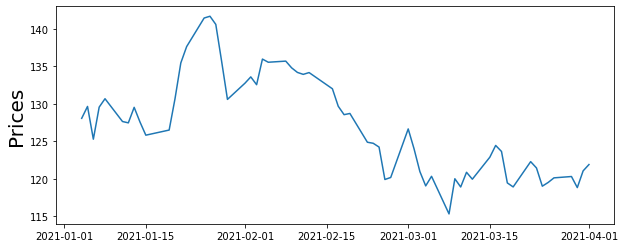

In [3]:
# visualize price data, clearly non-stationary
plt.figure(figsize=(10,4))
plt.plot(price_df["Adj Close"])
plt.ylabel('Prices', fontsize=20)
plt.show()

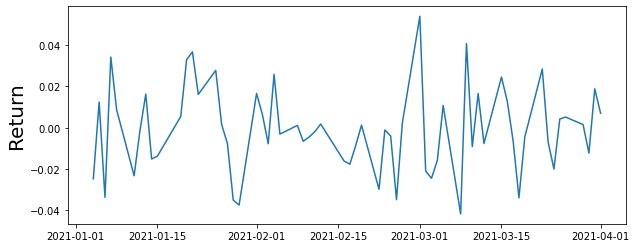

In [4]:
# visualize transformed data (returns), looks more stationary
plt.figure(figsize=(10,4))
plt.plot(price_df["returns"])
plt.ylabel('Return', fontsize=20)
plt.show()

In [5]:
# test for stationarity
def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
adfuller_test(price_df["returns"])

ADF Test Statistic : -8.139097115229275
p-value : 1.039792232115823e-12
#Lags Used : 0
Number of Observations Used : 61


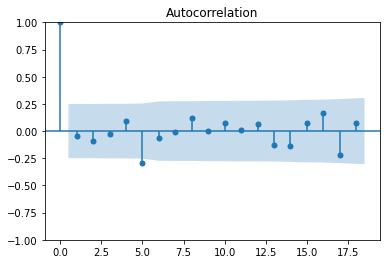

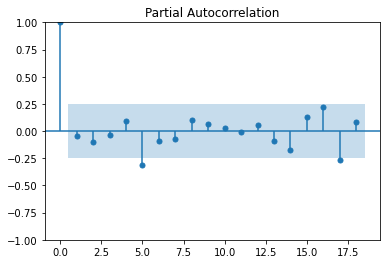

In [6]:
# review acf and pacf
acf = plot_acf(price_df["returns"])
pacf = plot_pacf(price_df["returns"])

# Trading Function

In [7]:
def run_simulation(df,amt,verbose=False,plot=True):
    
    # cant buy on the last day
    last_date = df.tail(1).index
    df.loc[last_date,"Buy_Flag"] = 0
    
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date in df.index:
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = df.loc[date,"Adj Close"]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #if buy flag is true, buy the stock
        if df.loc[date,"Buy_Flag"] == 1:
            curr_holding = True
            buy_price = df.loc[date,"Adj Close"]
            events_list.append(('b', date))
            if verbose:
                print('At day $%s'%date)
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Final Amount: $%s'%round(amt,2))


    if plot:
        plt.figure(figsize=(10,4))

        # plot prices
        plt.plot(df["Adj Close"])


        min_p = df["Adj Close"].min()
        max_p = df["Adj Close"].max()
        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(int(min_p*0.9),int(max_p*1.15)), event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nFinal Amount: $%s\nTotal Return: %s"%(ticker, round(amt,2), tot_return), fontsize=20)
        plt.show()

    return amt

# Benchmark: Random Buying
Every day, we flip a coin wether to buy the stock or not. If we buy, we always sell it at the end of the next trading day.

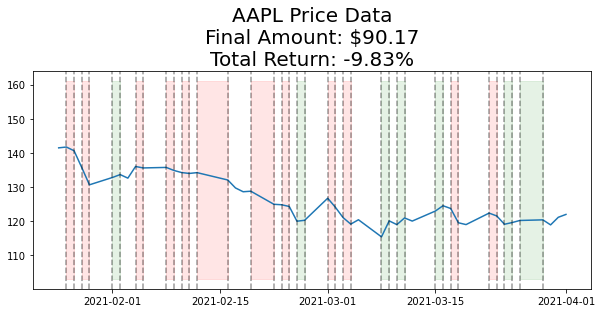

In [8]:
random_df = price_df[14:].copy()
random_df["Buy_Flag"] = 0
for date in random_df.index:
    # buy if coin flip is right (random number under 0.5)
    if np.random.random() < 0.5:
        random_df.loc[date,"Buy_Flag"] = 1
        
# run trading
final_amt = run_simulation(random_df,100,False)
        

In [9]:
# as this is totally random and thus different every time,
# we have to simulate it multiple times and view the average performance
final_amts = []
for runs in range(1000):
    random_df = price_df[14:].copy()
    random_df["Buy_Flag"] = 0
    for date in random_df.index:
        if np.random.random() < 0.5:
            random_df.loc[date,"Buy_Flag"] = 1

    final_amts.append(run_simulation(random_df,100,False,False))

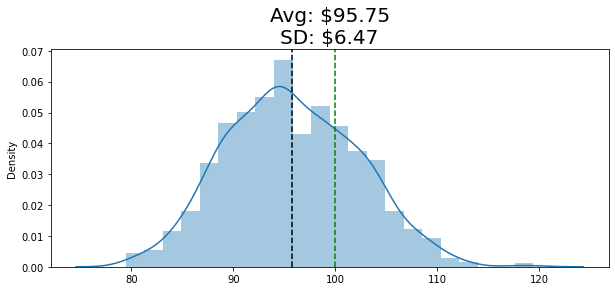

In [10]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)
plt.show()

# Some creative rule algorithm
For example, always buy when the last return was positive.

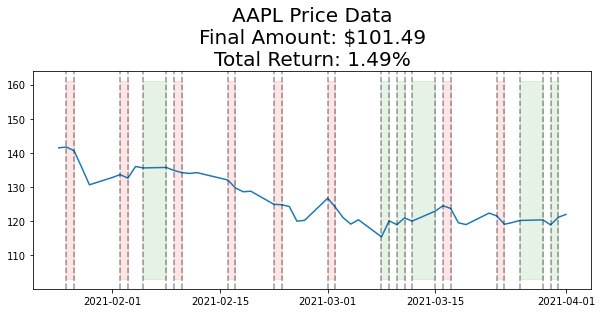

In [11]:
rule_df = price_df[14:].copy()
# buy when last return was > some value
threshold = 0.0
rule_df["Buy_Flag"] = np.where(rule_df["returns"].shift(1)>threshold,1,0)
        
# run trading
final_amt = run_simulation(rule_df,100,False)
        

# Sophisticated Time Series Model

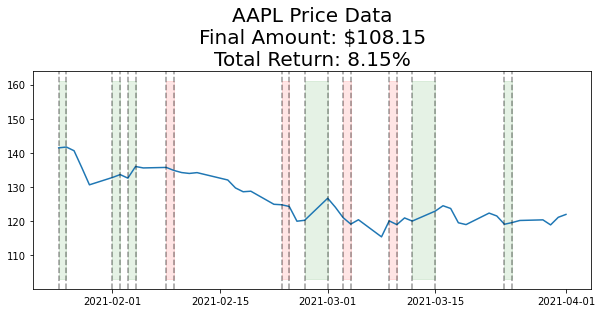

In [12]:
# define arima order
order = (5,0,0)
threshold = 0.005

# create df
ts_df = price_df.copy()
ts_df["Buy_Flag"] = 0

for date in ts_df.index[14:]:
    #get data until just before current date
    curr_data = ts_df.loc[:date,"returns"]
    
    #fit model
    model = ARIMA(curr_data, order=order,enforce_stationarity=False)
    model_fit = model.fit()

    #get forecast
    pred = model_fit.forecast().item()
    
    # buy if pred > threshold
    if pred > threshold:
        ts_df.loc[date,"Buy_Flag"] = 1
        
final_amt = run_simulation(ts_df[14:],100,False)
    
    

# Outlook
As we can see, it is often possible to find a working model for a specific stock and time period, but this model will most likely not work in the long-term, as soon as other investors find similar patterns the market will even it out as it is efficient in the long run. We can try to automate the whole process and be faster than other market participants. We could define a large number of stocks and automatically scan for significant patterns in the returns and thus adjust our trading algorithm. Many people try that and be the fastest and quickest, leading to high-frequency trading mostly controlled by algorithms.